## GE 461 Project 5

In [1]:
import numpy as np
from pathlib import Path
from collections import deque
from tqdm import tqdm
from skmultiflow.data import SEAGenerator, AGRAWALGenerator, ConceptDriftStream
from skmultiflow.meta import AdaptiveRandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
from skmultiflow.data.file_stream import FileStream
from sklearn.metrics import accuracy_score
from skmultiflow.lazy import SAMKNNClassifier
from skmultiflow.evaluation import EvaluatePrequential
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.meta import AdaptiveRandomForestClassifier
from skmultiflow.drift_detection import DDM, EDDM, ADWIN
import collections


## Generating Data Sets as Data Stream

### Synthetic AGRAWALGenerator and SEADataset.

In [ ]:
# Synthetic AGRAWALGenerator 

pos1 = 35_000
pos2 = 60_000
width = 1
n_samples = 100_000 

pos1 = 35_000
pos2 = 60_000
width = 1
n_samples = 100_000 

agr0 = AGRAWALGenerator(classification_function=0, random_state=1)
agr1 = AGRAWALGenerator(classification_function=1, random_state=2)
agr2 = AGRAWALGenerator(classification_function=2, random_state=3)

drift1 = ConceptDriftStream(stream=agr0, drift_stream=agr1,
                            position=pos1, width=width, random_state=7)
agr_stream = ConceptDriftStream(stream=drift1, drift_stream=agr2,
                                position=pos2, width=width, random_state=8)
agr_stream.prepare_for_use()
agr_stream.restart()


n_features = agr_stream.n_features
columns = [f"x{i}" for i in range(n_features)] + ["y"]

records = []
for _ in range(n_samples):
    X, y = agr_stream.next_sample()    
    records.append(list(X[0]) + [int(y[0])])

df = pd.DataFrame(records, columns=columns)

# — write out —
df.to_csv("agrawal_with_drift2.csv", index=False)
print(f"Saved {len(df)} samples with drift to agrawal_with_drift2.csv")

/Users/mustafacankanbalci/miniconda3/envs/datascience5/lib/python3.9/site-packages/skmultiflow/data/base_stream.py:191: FutureWarning: 'prepare_for_use' has been deprecated in v0.5.0 and will be removed in v0.7.0.
New instances of the Stream class are now ready to use after instantiation.
  warnings.warn(
/Users/mustafacankanbalci/miniconda3/envs/datascience5/lib/python3.9/site-packages/skmultiflow/data/concept_drift_stream.py:160: RuntimeWarning: overflow encountered in exp
  probability_drift = 1.0 / (1.0 + np.exp(x))


Saved 100000 samples with drift to agrawal_with_drift2.csv


In [ ]:
pos1 = 35_000
pos2 = 60_000
width = 1
n_samples = 100_000 

sea0 = SEAGenerator(classification_function=0, random_state=1)
sea1 = SEAGenerator(classification_function=1, random_state=2)
sea2 = SEAGenerator(classification_function=1, random_state=3)

drift1 = ConceptDriftStream(stream=sea0, drift_stream=sea1,
                            position=pos1, width=width, random_state=7)
sea_stream = ConceptDriftStream(stream=drift1, drift_stream=sea2,
                                position=pos2, width=width, random_state=8)
sea_stream.prepare_for_use()
sea_stream.restart()


n_features = sea_stream.n_features
columns = [f"x{i}" for i in range(n_features)] + ["y"]

records = []
for _ in range(n_samples):
    X, y = sea_stream.next_sample()    
    records.append(list(X[0]) + [int(y[0])])

df = pd.DataFrame(records, columns=columns)


df.to_csv("sea_with_drift.csv", index=False)
print(f"Saved {len(df)} samples with drift to sea_with_drift.csv")

/Users/mustafacankanbalci/miniconda3/envs/datascience5/lib/python3.9/site-packages/skmultiflow/data/base_stream.py:191: FutureWarning: 'prepare_for_use' has been deprecated in v0.5.0 and will be removed in v0.7.0.
New instances of the Stream class are now ready to use after instantiation.
  warnings.warn(
/Users/mustafacankanbalci/miniconda3/envs/datascience5/lib/python3.9/site-packages/skmultiflow/data/concept_drift_stream.py:160: RuntimeWarning: overflow encountered in exp
  probability_drift = 1.0 / (1.0 + np.exp(x))


Saved 100000 samples with drift to sea_with_drift.csv


# Concept Drift Handling

### 4.1 

In [ ]:
def test_function(classifier, stream, y_pred, y_true, acc_per_window,desc,window_size):
    window_size_n = n_samples // window_size  
    counter = 0                    
    counter_box = 1
    with tqdm(total=window_size, desc=desc) as bar:
        while counter < n_samples and stream.has_more_samples():
            X, y = stream.next_sample(window_size_n)
            n_in_window = len(y)

            preds = classifier.predict(X)
        
            classifier.partial_fit(X, y)

            end = counter + n_in_window
            y_true[counter:end] = y
            y_pred[counter:end] = preds

            acc = accuracy_score(y, preds)          
            acc_per_window.append(acc)
            
            # bookkeeping
            counter += n_in_window
            counter_box += 1
            bar.update(1)

    print(f"\nProcessed {counter:,d} instances")
    print(f"Overall Accuracy: {np.mean(np.array(acc_per_window)):0.4f}")
    return acc_per_window

    

#### SEADataset 

In [ ]:
# Classfication Modules 
window_size = 20 
n_samples = 100_000
arf_reg = AdaptiveRandomForestClassifier()

# Stream 
stream_sea = FileStream("sea_with_drift.csv")

# Pretraining 
X0, y0 = stream_sea.next_sample(2000)
arf_reg.partial_fit(X0, y0)         

# allocate result buffers
y_true_arf_sea = np.zeros(n_samples, dtype=int)
y_pred_arf_sea = np.zeros(n_samples, dtype=int)
acc_per_window_arf_sea = []

stream_sea.restart()

# Run Evaluation 
acc_curve_arf_sea = test_function(
    classifier     = arf_reg,
    stream         = stream_sea,
    y_pred         = y_true_arf_sea,
    y_true         = y_pred_arf_sea,
    acc_per_window = acc_per_window_arf_sea,
    desc = "ARF on SEA"
)


ARF on SEA: 100%|██████████| 20/20 [01:53<00:00,  5.68s/it]


Processed 100,000 instances
Overall Accuracy: 0.9941


In [ ]:
sam_knn = SAMKNNClassifier(n_neighbors=5, weighting='distance', max_window_size=window_size,stm_size_option='maxACCApprox', use_ltm=False)

# Stream 
stream_sea = FileStream("sea_with_drift.csv")

# Pretraining
X0, y0 = stream_sea.next_sample(2000)
sam_knn.partial_fit(X0, y0)         # classes=[0,1] are passed internally

# allocate result buffers
y_true_sam_knn = np.zeros(n_samples, dtype=int)
y_pred_sam_knn = np.zeros(n_samples, dtype=int)
acc_per_window_sam_knn_sea = []

stream_sea.restart()

acc_curve_sam_knn_sea = test_function(
    classifier     = sam_knn,
    stream         = stream_sea,
    y_pred         = y_true_sam_knn,
    y_true         = y_pred_sam_knn,
    acc_per_window = acc_per_window_sam_knn_sea,
    desc = "SAMKNN on SEA"
)

SAMKNN on SEA: 100%|██████████| 20/20 [00:01<00:00, 13.27it/s]


Processed 100,000 instances
Overall Accuracy: 0.8476


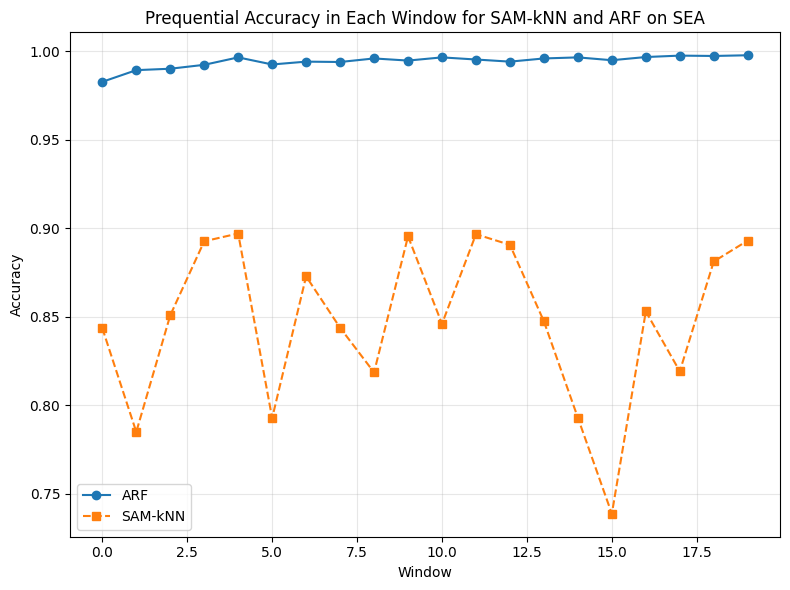

In [8]:
plt.figure(figsize=(8, 6))

# Plot with markers and labels for the legend
plt.plot(acc_curve_arf_sea, marker='o', linestyle='-', label='ARF')
plt.plot(acc_curve_sam_knn_sea, marker='s', linestyle='--', label='SAM-kNN')

plt.title("Prequential Accuracy in Each Window for SAM-kNN and ARF on SEA")
plt.xlabel('Window')
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)

# Add legend in the best location
plt.legend(loc='best')

plt.tight_layout()
plt.show()

##### AGRAWALDataset

In [ ]:
# Classfication Modules 
window_size = 20 
arf_reg = AdaptiveRandomForestClassifier()

# Stream 
stream_agr = FileStream("agrawal_with_drift2.csv")

# ── mandatory first fit so each learner sees the class list
X0, y0 = stream_agr.next_sample(2000)
arf_reg.partial_fit(X0, y0)         # classes=[0,1] are passed internally

# allocate result buffers
y_true_arf_sea = np.zeros(n_samples, dtype=int)
y_pred_arf_sea = np.zeros(n_samples, dtype=int)
acc_per_window_arf_agr = []

stream_agr.restart()

# ────────────────────────────────────────────────────────────────
# 3.  Run evaluation
# ────────────────────────────────────────────────────────────────
acc_curve_arf_agr = test_function(
    classifier     = arf_reg,
    stream         = stream_agr,
    y_pred         = y_true_arf_sea,
    y_true         = y_pred_arf_sea,
    acc_per_window = acc_per_window_arf_agr,
    desc = "ARF on AGR"
)

ARF on AGR: 100%|██████████| 20/20 [03:06<00:00,  9.33s/it]


Processed 100,000 instances
Overall Accuracy: 0.9193


In [ ]:
sam_knn = SAMKNNClassifier(n_neighbors=5, weighting='distance', max_window_size=window_size,stm_size_option='maxACCApprox', use_ltm=False)

# Stream 
stream_agr = FileStream("agrawal_with_drift2.csv")

# Pretraining 
X0, y0 = stream_agr.next_sample(2000)
sam_knn.partial_fit(X0, y0)        

# allocate result buffers
y_true_sam_knn = np.zeros(n_samples, dtype=int)
y_pred_sam_knn = np.zeros(n_samples, dtype=int)
acc_per_window_sam_knn_agr = []

stream_agr.restart()


acc_curve_sam_knn_agr = test_function(
    classifier     = sam_knn,
    stream         = stream_agr,
    y_pred         = y_true_sam_knn,
    y_true         = y_pred_sam_knn,
    acc_per_window = acc_per_window_sam_knn_agr,
    desc = "SAMKNN on AGR"
)

SAMKNN on AGR: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Processed 100,000 instances
Overall Accuracy: 0.5375


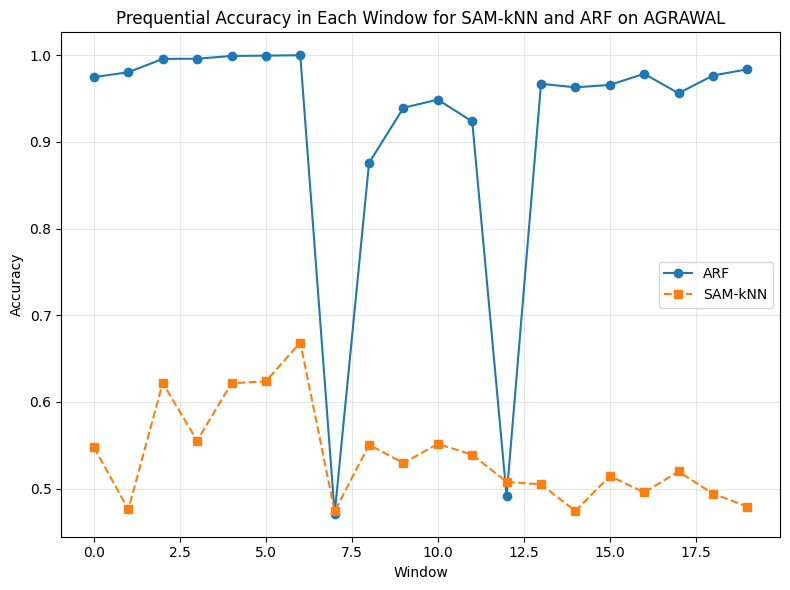

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(acc_curve_arf_agr, marker='o', linestyle='-', label='ARF')
plt.plot(acc_curve_sam_knn_agr, marker='s', linestyle='--', label='SAM-kNN')

plt.title("Prequential Accuracy in Each Window for SAM-kNN and ARF on AGRAWAL")
plt.xlabel('Window')
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)

plt.legend(loc='best')

plt.tight_layout()
plt.show()

##### Spam

In [12]:
# Classfication Modules 
arf_reg = AdaptiveRandomForestClassifier()

# Stream 
stream_spam = FileStream("spam.csv")
n_samples = pd.read_csv("spam.csv").shape[0]

# ── mandatory first fit so each learner sees the class list
X0, y0 = stream_spam.next_sample(400)
arf_reg.partial_fit(X0, y0)         # classes=[0,1] are passed internally

# allocate result buffers
y_true_arf_sea = np.zeros(n_samples, dtype=int)
y_pred_arf_sea = np.zeros(n_samples, dtype=int)
acc_per_window_arf_spam = []

stream_spam.restart()

# ────────────────────────────────────────────────────────────────
# 3.  Run evaluation
# ────────────────────────────────────────────────────────────────
acc_curve_arf_spam = test_function(
    classifier     = arf_reg,
    stream         = stream_spam,
    y_pred         = y_true_arf_sea,
    y_true         = y_pred_arf_sea,
    acc_per_window = acc_per_window_arf_spam,
    desc = "ARF on SPAM"
)

ARF on SPAM: 21it [00:41,  1.98s/it]                        


Processed 6,213 instances
Overall Accuracy: 0.8735


In [ ]:
sam_knn = SAMKNNClassifier(n_neighbors=5, weighting='distance', max_window_size=window_size,stm_size_option='maxACCApprox', use_ltm=False)

# Stream 
stream_spam = FileStream("spam.csv")
n_samples = pd.read_csv("spam.csv").shape[0]

# Pretraining 
X0, y0 = stream_spam.next_sample(400)
sam_knn.partial_fit(X0, y0)         # classes=[0,1] are passed internally

# allocate result buffers
y_true_sam_knn = np.zeros(n_samples, dtype=int)
y_pred_sam_knn = np.zeros(n_samples, dtype=int)
acc_per_window_sam_knn_spam = []

stream_spam.restart()

# Evaluation 
acc_curve_sam_knn_spam = test_function(
    classifier     = sam_knn,
    stream         = stream_spam,
    y_pred         = y_true_sam_knn,
    y_true         = y_pred_sam_knn,
    acc_per_window = acc_per_window_sam_knn_spam,
    desc = "SAMKNN on SPAM"
)

SAMKNN on SPAM: 21it [00:00, 67.56it/s]                        


Processed 6,213 instances
Overall Accuracy: 0.7743


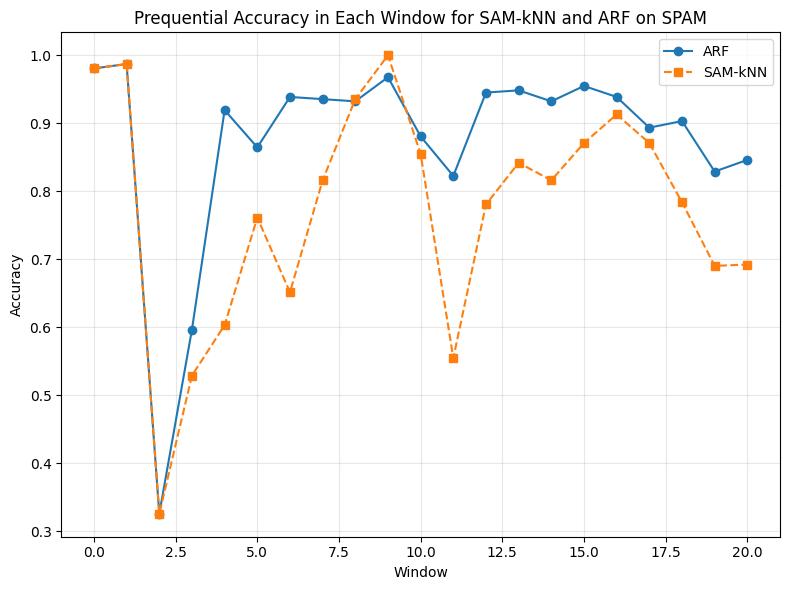

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(acc_curve_arf_spam, marker='o', linestyle='-', label='ARF')
plt.plot(acc_curve_sam_knn_spam, marker='s', linestyle='--', label='SAM-kNN')

plt.title("Prequential Accuracy in Each Window for SAM-kNN and ARF on SPAM")
plt.xlabel('Window')
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)

plt.legend(loc='best')

plt.tight_layout()
plt.show()

##### Electricty

In [ ]:
# Classfication Modules 

arf_reg = AdaptiveRandomForestClassifier()

# Stream 
stream_elec = FileStream("elec.csv")
n_samples = pd.read_csv("elec.csv").shape[0]


# Pretraining 
X0, y0 = stream_elec.next_sample(200)
arf_reg.partial_fit(X0, y0)         # classes=[0,1] are passed internally

# allocate result buffers
y_true_arf_sea = np.zeros(n_samples, dtype=int)
y_pred_arf_sea = np.zeros(n_samples, dtype=int)
acc_per_window_arf_elec = []

stream_elec.restart()

acc_curve_arf_elec = test_function(
    classifier     = arf_reg,
    stream         = stream_elec,
    y_pred         = y_true_arf_sea,
    y_true         = y_pred_arf_sea,
    acc_per_window = acc_per_window_arf_elec,
    desc = "ARF on ELEC")

ARF on ELEC: 21it [01:20,  3.83s/it]                        


Processed 45,312 instances
Overall Accuracy: 0.7726


In [ ]:
sam_knn = SAMKNNClassifier(n_neighbors=5, weighting='distance', max_window_size=window_size,stm_size_option='maxACCApprox', use_ltm=False)

# Stream 
stream_elec = FileStream("elec.csv")
n_samples = pd.read_csv("elec.csv").shape[0]


# Pretraining 
X0, y0 = stream_elec.next_sample(200)
sam_knn.partial_fit(X0, y0)         # classes=[0,1] are passed internally

# allocate result buffers
y_true_sam_knn = np.zeros(n_samples, dtype=int)
y_pred_sam_knn = np.zeros(n_samples, dtype=int)
acc_per_window_sam_knn_elec = []

stream_elec.restart()

# Evaluation 
acc_curve_sam_knn_elec = test_function(
    classifier     = sam_knn,
    stream         = stream_elec,
    y_pred         = y_true_sam_knn,
    y_true         = y_pred_sam_knn,
    acc_per_window = acc_per_window_sam_knn_elec,
    desc = "SAMKNN on ELEC")

SAMKNN on ELEC: 21it [00:00, 30.84it/s]                        


Processed 45,312 instances
Overall Accuracy: 0.5644


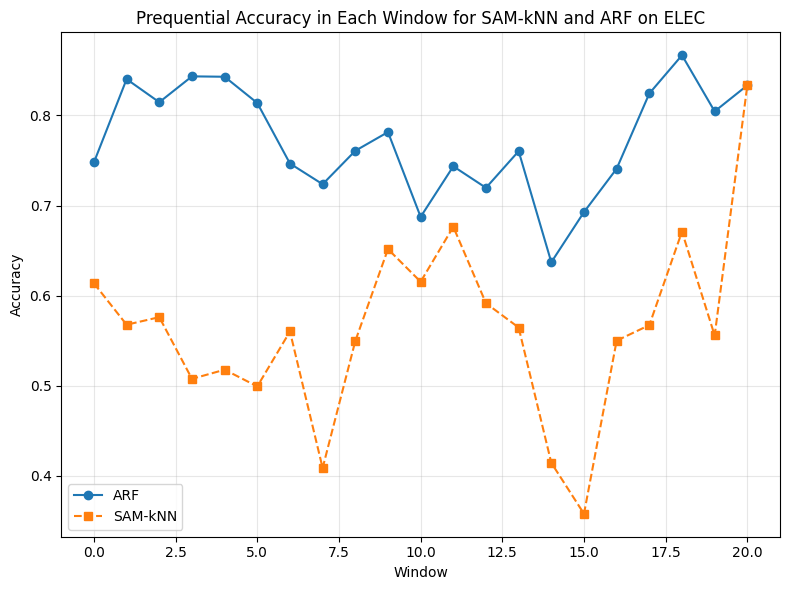

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(acc_curve_arf_elec, marker='o', linestyle='-', label='ARF')
plt.plot(acc_curve_sam_knn_elec, marker='s', linestyle='--', label='SAM-kNN')

plt.title("Prequential Accuracy in Each Window for SAM-kNN and ARF on ELEC")
plt.xlabel('Window')
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)

plt.legend(loc='best')

plt.tight_layout()
plt.show()

### 4.2 

In [ ]:
class ActiveLearner:
    def __init__(self,
                 detector_cls,
                 window_size: int = 100):
        self.detector_cls   = detector_cls
        self.detector       = detector_cls()
        self.clf            = HoeffdingTreeClassifier()
        self.window         = collections.deque(maxlen=window_size)

    def _acc(self) -> float:
        return sum(self.window) / len(self.window) if self.window else 0.0

    def predict(self, X):
        return self.clf.predict(X)

    def partial_fit(self, X, y, classes=[0, 1]) -> bool:
        preds = self.clf.predict(X)
        self.clf.partial_fit(X, y, classes=classes)

        drift = False
        for yi, pi in zip(y, preds):
            correct = int(yi == pi)
            self.window.append(correct)
            self.detector.add_element(int(not correct))
            if self.detector.detected_change():
                drift = True

        if len(self.window) == self.window.maxlen:
                drift = True
        return drift

    def weight(self, eps: float = 1e-3) -> float:
        return max(self._acc(), eps)


class ActiveEnsemble:
    def __init__(self,
                 n_learners      : int = 3,
                 detectors_pool  : tuple[type, ...] = (DDM, EDDM, ADWIN),
                 window_size     : int = 100,
                ):
        self.pool = detectors_pool
        self.n    = n_learners
        self.winsize = window_size

        self.learners = [
            ActiveLearner(detector_cls=self.pool[i % len(self.pool)],
                          window_size = self.winsize)
            for i in range(self.n)
        ]

    def _replace(self, idx: int):
        det_cls = self.learners[idx].detector_cls
        self.learners[idx] = ActiveLearner(det_cls,window_size=self.winsize)

    def predict(self, X):
        votes = np.zeros((len(X), 2))                 
        for l in self.learners:
            preds = l.predict(X)
            w     = l.weight()
            for i, p in enumerate(preds):
                votes[i, int(p)] += w
        return np.argmax(votes, axis=1)

    def partial_fit(self, X, y, classes=[0, 1]):
        for idx, l in enumerate(self.learners):
            drift = l.partial_fit(X, y, classes=classes)
            if drift:
                self._replace(idx)
                self.learners[idx].partial_fit(X, y, classes=classes)

In [ ]:
n_samples = 100_000
stream_sea = FileStream("agrawal_with_drift2.csv")
window_size = 20

ae = ActiveEnsemble(n_learners=3, window_size=20)

# Pretraining 
X0, y0 = stream_sea.next_sample(2000)
ae.partial_fit(X0, y0)         


y_true = np.zeros(n_samples, dtype=int)
y_pred = np.zeros(n_samples, dtype=int)
acc_per_window = []

stream_sea.restart()

# Evaluation 
acc_curve_ae_agr = test_function(
    classifier     = ae,
    stream         = stream_sea,
    y_pred         = y_pred,
    y_true         = y_true,
    acc_per_window = acc_per_window,
    desc = "Active Ensemble on AGR",
    window_size=window_size
)



Active Ensemble on AGR: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]


Processed 100,000 instances
Overall Accuracy: 0.7250


In [33]:
n_samples = 100_000
stream_sea = FileStream("sea_with_drift.csv")
window_size =100

# Passive ensemble with 3 learners, 100-size window, 70 % threshold
ae = ActiveEnsemble(n_learners=3, window_size=100)

# ── mandatory first fit so each learner sees the class list
X0, y0 = stream_sea.next_sample(2000)
ae.partial_fit(X0, y0)         

# allocate result buffers
y_true = np.zeros(n_samples, dtype=int)
y_pred = np.zeros(n_samples, dtype=int)
acc_per_window = []

stream_sea.restart()

acc_curve_ae_sea = test_function(
    classifier     = ae,
    stream         = stream_sea,
    y_pred         = y_pred,
    y_true         = y_true,
    acc_per_window = acc_per_window,
    desc = "Active Ensemble on SEA",
    window_size=window_size
)



Active Ensemble on SEA: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Processed 100,000 instances
Overall Accuracy: 0.9499


In [34]:

stream_sea = FileStream("spam.csv")
n_samples = pd.read_csv("spam.csv").shape[0]

# Passive ensemble with 3 learners, 100-size window, 70 % threshold
ae = ActiveEnsemble(n_learners=3, window_size=20)

# ── mandatory first fit so each learner sees the class list
X0, y0 = stream_sea.next_sample(2000)
ae.partial_fit(X0, y0)         # classes=[0,1] are passed internally

# allocate result buffers
y_true = np.zeros(n_samples, dtype=int)
y_pred = np.zeros(n_samples, dtype=int)
acc_per_window = []

stream_sea.restart()

acc_curve_ae_spam = test_function(
    classifier     = ae,
    stream         = stream_sea,
    y_pred         = y_pred,
    y_true         = y_true,
    acc_per_window = acc_per_window,
    desc = "Active Ensemble on SPAM",
    window_size=window_size
)



Active Ensemble on SPAM: 101it [01:01,  1.65it/s]                         


Processed 6,213 instances
Overall Accuracy: 0.7276


In [37]:

stream_sea = FileStream("elec.csv")
n_samples = pd.read_csv("elec.csv").shape[0]


ae = ActiveEnsemble(n_learners=3, window_size=20)

# ── mandatory first fit so each learner sees the class list
X0, y0 = stream_sea.next_sample(2000)
ae.partial_fit(X0, y0)         # classes=[0,1] are passed internally

# allocate result buffers
y_true = np.zeros(n_samples, dtype=int)
y_pred = np.zeros(n_samples, dtype=int)
acc_per_window = []

stream_sea.restart()

acc_curve_ae_elec = test_function(
    classifier     = ae,
    stream         = stream_sea,
    y_pred         = y_pred,
    y_true         = y_true,
    acc_per_window = acc_per_window,
    desc = "Active Ensemble on ELEC",
    window_size=window_size
)



Active Ensemble on ELEC: 101it [00:10,  9.30it/s]                         


Processed 45,312 instances
Overall Accuracy: 0.7502


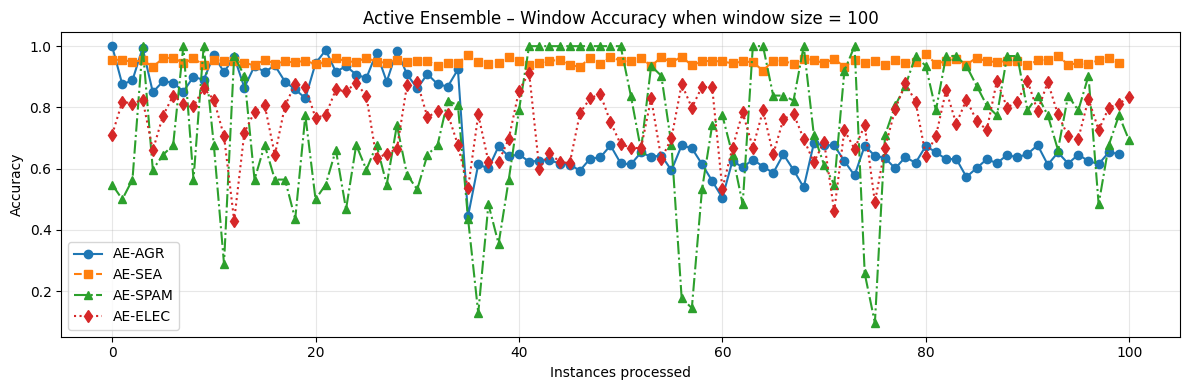

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(acc_curve_ae_agr, marker='o', linestyle='-', label='AE-AGR')
plt.plot(acc_curve_ae_sea, marker='s', linestyle='--', label='AE-SEA')
plt.plot(acc_curve_ae_spam, marker='^', linestyle='-.', label='AE-SPAM')
plt.plot(acc_curve_ae_elec, marker='d', linestyle=':', label='AE-ELEC')

plt.title("Active Ensemble – Window Accuracy when window size = 100")
plt.xlabel("Instances processed")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)

plt.legend(loc='best')

plt.tight_layout()
plt.show()

### 4.3

In [ ]:
class PassiveLearner:
    def __init__(self, window_size: int = 100, passive_threshold: float = 0.70):
        self.clf = HoeffdingTreeClassifier()
        self.window_size = window_size
        self.passive_threshold = passive_threshold
        self._win = collections.deque(maxlen=window_size)  

    def _window_accuracy(self) -> float:
        return sum(self._win) / len(self._win) if self._win else 0.0

    def predict(self, X):
        return self.clf.predict(X)

    def partial_fit(self, X, y, classes=[0, 1]):
        self.clf.partial_fit(X, y, classes=classes)

        pred = int(self.clf.predict(X)[0])
        self._win.append(int(pred == y[0]))

        if len(self._win) == self.window_size and self._window_accuracy() < self.passive_threshold:
            return True        
        return False

In [ ]:
class PassiveEnsemble:
    def __init__(
        self,
        n_learners: int = 3,
        window_size: int = 100,
        passive_threshold: float = 0.70,
    ):
        self.window_size = window_size
        self.passive_threshold = passive_threshold
        self.learners = [
            PassiveLearner(window_size, passive_threshold) for _ in range(n_learners)
        ]

    def _learner_weight(self, learner: PassiveLearner) -> float:
        return max(learner._window_accuracy(), 1e-3)

    def predict(self, X):
        votes = np.zeros((len(X), 2))          
        for l in self.learners:
            preds = l.predict(X)
            w = self._learner_weight(l)
            for i, p in enumerate(preds):
                votes[i, int(p)] += w
        return np.argmax(votes, axis=1)

    def partial_fit(self, X, y):
        for i, learner in enumerate(self.learners):
            drift = learner.partial_fit(X, y)
            if drift:
                self.learners[i] = PassiveLearner(
                    self.window_size, self.passive_threshold
                )
                self.learners[i].partial_fit(X, y)
                

In [ ]:
n_samples = 100_000
stream_sea = FileStream("sea_with_drift.csv")

window_size = 20 
pe = PassiveEnsemble(n_learners=3, window_size=20, passive_threshold=0.7)

# Pretraining
X0, y0 = stream_sea.next_sample(2000)
pe.partial_fit(X0, y0)         

# allocate result buffers
y_true = np.zeros(n_samples, dtype=int)
y_pred = np.zeros(n_samples, dtype=int)
acc_per_window = []

stream_sea.restart()

acc_curve_pe_sea = test_function(
    classifier     = pe,
    stream         = stream_sea,
    y_pred         = y_pred,
    y_true         = y_true,
    acc_per_window = acc_per_window,
    desc = "Passive Ensemble on SEA",
window_size=window_size
)

Passive Ensemble on SEA: 100%|██████████| 100/100 [00:10<00:00,  9.30it/s]


Processed 100,000 instances
Overall Accuracy: 0.9877


In [ ]:
n_samples = 100_000
stream_sea = FileStream("agrawal_with_drift2.csv")
window_size = 20 

pe = PassiveEnsemble(n_learners=3, window_size=20, passive_threshold=0.7)

# Evaluation 
X0, y0 = stream_sea.next_sample(2000)
pe.partial_fit(X0, y0)         # classes=[0,1] are passed internally

# allocate result buffers
y_true = np.zeros(n_samples, dtype=int)
y_pred = np.zeros(n_samples, dtype=int)
acc_per_window = []

stream_sea.restart()

# Evaluation
acc_curve_pe_agr = test_function(
    classifier     = pe,
    stream         = stream_sea,
    y_pred         = y_pred,
    y_true         = y_true,
    acc_per_window = acc_per_window,
    desc = "Passive Ensemble on AGR",
    window_size=window_size
)

Passive Ensemble on AGR: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Processed 100,000 instances
Overall Accuracy: 0.9540


In [ ]:
window_size = 20 
stream_sea = FileStream("spam.csv")
n_samples = pd.read_csv("spam.csv").shape[0]
# Passive ensemble with 3 learners, 100-size window, 70 % threshold
pe = PassiveEnsemble(n_learners=3, window_size=20, passive_threshold=0.7)

# ── mandatory first fit so each learner sees the class list
X0, y0 = stream_sea.next_sample(200)
pe.partial_fit(X0, y0)         # classes=[0,1] are passed internally

# allocate result buffers
y_true = np.zeros(n_samples, dtype=int)
y_pred = np.zeros(n_samples, dtype=int)
acc_per_window = []

stream_sea.restart()

acc_curve_pe_spam = test_function(
    classifier     = pe,
    stream         = stream_sea,
    y_pred         = y_pred,
    y_true         = y_true,
    acc_per_window = acc_per_window,
    desc = "Passive Ensemble on SPAM",
    window_size=window_size
)



Passive Ensemble on SPAM: 101it [00:50,  2.00it/s]                         


Processed 6,213 instances
Overall Accuracy: 0.8464


In [ ]:
stream_sea = FileStream("elec.csv")
n_samples = pd.read_csv("elec.csv").shape[0]

pe = PassiveEnsemble(n_learners=3, window_size=20, passive_threshold=0.7)

# Pretraining 
X0, y0 = stream_sea.next_sample(200)
pe.partial_fit(X0, y0)         

# allocate result buffers
y_true = np.zeros(n_samples, dtype=int)
y_pred = np.zeros(n_samples, dtype=int)
acc_per_window = []

stream_sea.restart()

# Evaluation 
acc_curve_pe_elec = test_function(
    classifier     = pe,
    stream         = stream_sea,
    y_pred         = y_pred,
    y_true         = y_true,
    acc_per_window = acc_per_window,
    desc = "Passive Ensemble on Elec",
     window_size=window_size
)



Passive Ensemble on Elec: 101it [00:06, 15.04it/s]                         


Processed 45,312 instances
Overall Accuracy: 0.7492


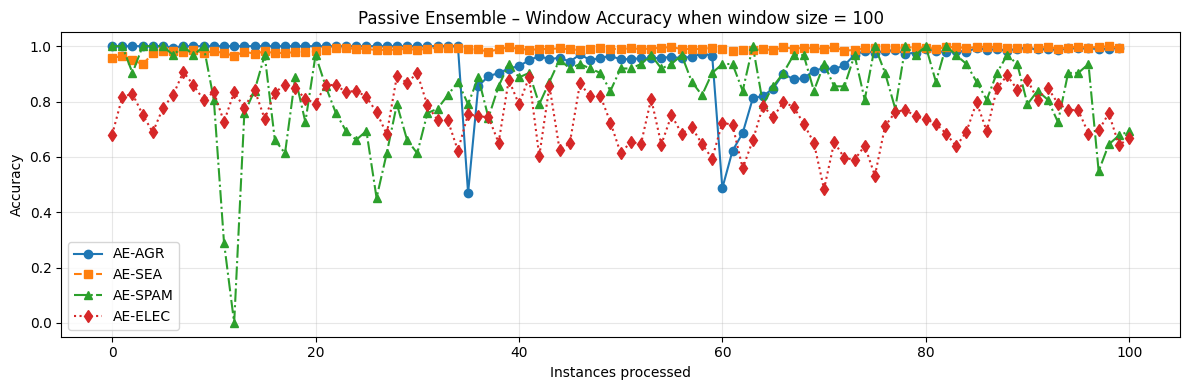

In [48]:
plt.figure(figsize=(12, 4))

plt.plot(acc_curve_pe_agr, marker='o', linestyle='-', label='AE-AGR')
plt.plot(acc_curve_pe_sea, marker='s', linestyle='--', label='AE-SEA')
plt.plot(acc_curve_pe_spam, marker='^', linestyle='-.', label='AE-SPAM')
plt.plot(acc_curve_pe_elec, marker='d', linestyle=':', label='AE-ELEC')

plt.title("Passive Ensemble – Window Accuracy when window size = 100" )
plt.xlabel("Instances processed")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)

# place legend in the best spot
plt.legend(loc='best')

plt.tight_layout()
plt.show()